In [1]:
# 기본 import 패키지
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

### 커널 서포트 벡터 머신
커널 서포트 벡터 머신*kernelized support vector machines*은 선형 서포트 벡터 머신을 입력 데이터에서 단순한 초평면으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것이다.

#### 선형 모델과 비선형 특성
직선과 초평면은 유연하지 못하여 저차원 데이터셋에서는 선형 모델이 매우 제한적이다. 선형 모델을 유연하게 만드는 방법중  하나는 특성끼리 곱하거나 거듭제곱하는 식으로 새로운 특성을 추가하는 것이다.

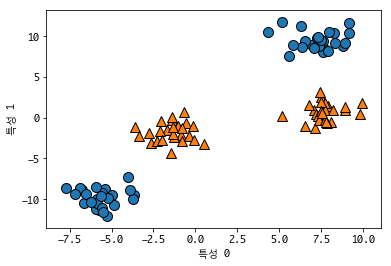

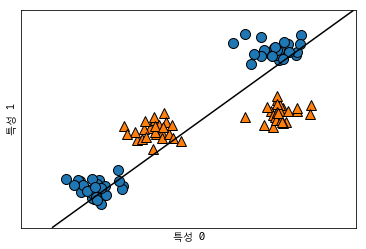

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

plt.show()

from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

선형 모델은 직선으로만 데이터를 나눌 수 있어 이런 데이터셋에는 잘 맞지 않는다.

두번째 특성을 제곱한 ${특성1}^2$을 새로운 특성으로 추가해 3차원 데이터 포인트로 표현한다.

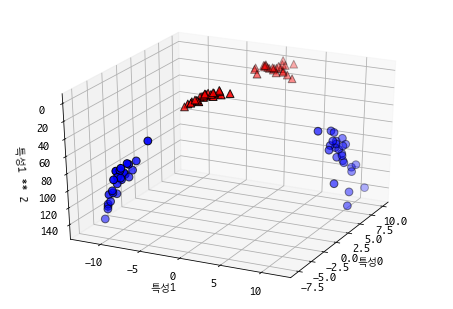

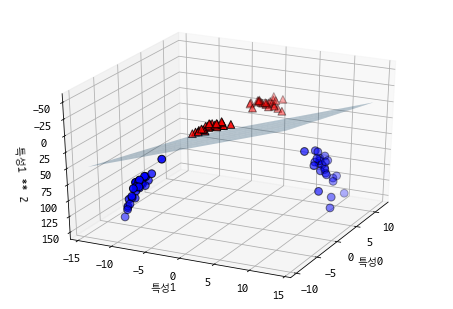

In [10]:
# 두 번째 특성을 제곱하여 추가합니다
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0 인 포인트를 먼저 그리고 그 다음 y == 1 인 포인트를 그립니다
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

새로운 데이터셋에서는 평면을 사용해 두 클래스를 구분할 수 있다. 원래 특성으로 투영해보면 이 선형 SVM 모델은 선형이 아니라 타원에 가까운 모습이 된다.

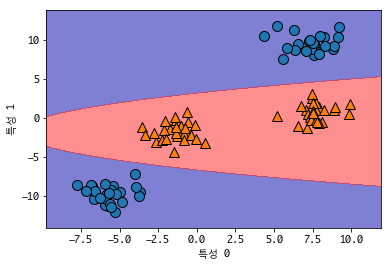

In [11]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### 커널 기법
비선형 특성을 추가하면 선형 모델이 강력해지지만 어떤 특성을 추가해야될지 모르고 많은 특성을 추가하면 연산 비용이 커진다. **커널 기법** *kernel trick*을 사용해 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리(스칼라 곱을 계산할 수 있다.

서포트 벡터 머신에서 데이터를 고차원 공간에 매핑하는데 많이 사용하는 방법은 두 가지이다.  
* 다항식 커널: 특성의 가능한 조합을 지정된 차수까지 모든 계산
* RBF*radial basis function* 커널: 가우시안*Gaussian* 커널이라고도 불린다. 차원이 무한한 특성 공간에 매핑한다. 모든 차수의 모든 다항식을 고려하는 것으로 이해하면 좋다. 지수 함수의 테일러 전개 때문에 특성의 중요도는 고차항이 될수록 줄어든다.

#### SVM 이해하기

#### SVM 매개변수 튜닝

#### SVM을 위한 데이터 전처리

#### 장단점과 매개변수